In [1]:
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from keras.models import load_model
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
import cv2
import os

def plot_random_test(test_images, test_labels, pred_labels, figsize=(12, 8)):
    if test_images.shape[0] > 1: 
        img_num = random.randint(0, test_images.shape[0]-1)
    else: 
        img_num = 0
    plt.style.use('dark_background')
    plt.figure(figsize=figsize)
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_images[img_num])
    plt.subplot(232)
    plt.title('Testing Label')
    print(test_labels.shape)
    plt.imshow(test_labels[img_num])
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(pred_labels[img_num])
    plt.show()
    print('Unique values in test mask: ', np.unique(test_labels[img_num]))
    print('Unique values in pred mask: ', np.unique(pred_labels[img_num]))

In [171]:
# Data directories
PATCH_SIZE = 1024
TRAIN_IMAGE_DIRECTORY_PATH = '../data/data_for_training_and_testing_n' + str(PATCH_SIZE) + '/train_images'
TRAIN_MASK_DIRECTORY_PATH = '../data/data_for_training_and_testing_n' + str(PATCH_SIZE) + '/train_masks'
VAL_IMAGE_DIRECTORY_PATH = '../data/data_for_training_and_testing_n' + str(PATCH_SIZE) + '/val_images'
VAL_MASK_DIRECTORY_PATH = '../data/data_for_training_and_testing_n' + str(PATCH_SIZE) + '/val_masks'

# Model info 
N_CLASSES = 6
BATCH_SIZE = 5

file_location = TRAIN_IMAGE_DIRECTORY_PATH + '/train/'
file_path = file_location + os.listdir(file_location)[0]
input_shape = cv2.imread(file_path, 1).shape

BACKBONE = 'mit_b3'
MODEL_NAME = 'unet_mit_b3_imagenet_3batch_6classes_p1024_v2.pth'
MODEL_PATH = "../models/" + MODEL_NAME

PYTORCH = MODEL_NAME[-3:] == 'pth'
print(PYTORCH)

True


In [158]:
if PYTORCH:
    from torch_load_data import *
    preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE)
    val_img_gen = Dataset(
        VAL_IMAGE_DIRECTORY_PATH + '/val/', 
        VAL_MASK_DIRECTORY_PATH + '/val/', 
        augmentation=None, 
        preprocessing= get_preprocessing(preprocess_input),
        classes=[str(x) for x in range(N_CLASSES)],
    )
    model = torch.load(MODEL_PATH)

    # augmented_fragment = torch.from_numpy(augmented_fragment.astype('float32')).permute(0, 3, 1, 2)
    # augmented_fragment = augmented_fragment.to(device='cuda')
    # prediction = model.predict(augmented_fragment)
    # prediction = prediction.cpu().permute(0, 2, 3, 1).numpy()

else: 
    from tf_load_data import *
    sampler = LoadData(
        train_img_path=TRAIN_IMAGE_DIRECTORY_PATH,
        train_mask_path=TRAIN_MASK_DIRECTORY_PATH,
        val_img_path=VAL_IMAGE_DIRECTORY_PATH,
        val_mask_path=VAL_MASK_DIRECTORY_PATH,
        backbone=BACKBONE,
        batch_size=BATCH_SIZE,
        n_classes=N_CLASSES,
        input_shape=input_shape
    )
    _, val_img_gen = sampler.create_generators()
    model = load_model(MODEL_PATH, compile=False)

In [177]:
if PYTORCH:
    IMG_NUM = 1
    test_image, test_mask = val_img_gen[IMG_NUM]
    test_mask_argmax = np.argmax(test_mask, axis=0).expand(1, -1, -1).numpy()
    test_pred = model.predict(test_image.expand(1, -1, -1, -1).to(device='cuda'))
    test_pred_argmax = np.argmax(test_pred.cpu().expand(1, -1, -1, -1).permute(0, 2, 3, 1).numpy(), axis=3)
    plot_image = test_image.expand(1, -1, -1, -1).permute(0, 2, 3, 1).numpy()
else: 
    test_image, test_mask = val_img_gen.__next__()
    test_mask_argmax = np.argmax(test_mask, axis=3) 
    test_pred = model.predict(test_image)
    test_pred_argmax = np.argmax(test_pred, axis=3)

c:\Users\mg\anaconda3\envs\torch-env\lib\site-packages\segmentation_models_pytorch\base\modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


In [178]:
IOU_keras = MeanIoU(num_classes=N_CLASSES)  
IOU_keras.update_state(test_pred_argmax, test_mask_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
print('Batch shape: ', test_image.shape)

Mean IoU = 0.63241184
Batch shape:  torch.Size([3, 1024, 1024])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 1024, 1024)


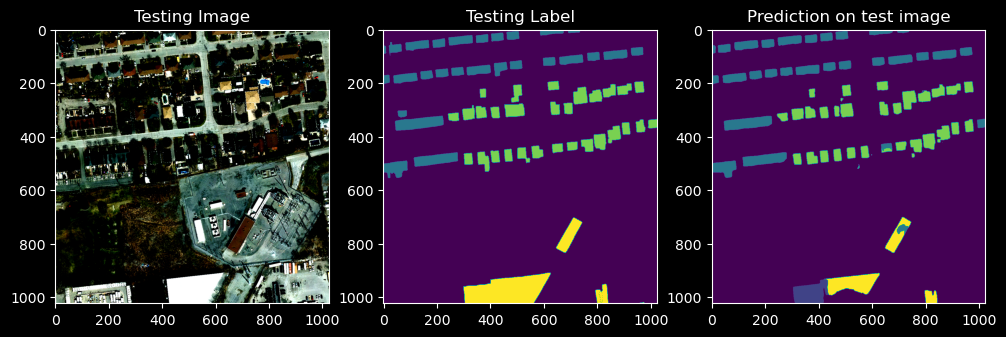

Unique values in test mask:  [0 2 4 5]
Unique values in pred mask:  [0 1 2 4 5]


In [179]:
plot_random_test(plot_image, test_mask_argmax, test_pred_argmax)

--- 

### View training history

In [6]:
from matplotlib import pyplot as plt
import pandas as pd

# history = np.load(MODEL_PATH[:-5] + '_history.npy', allow_pickle=True)
# history = np.load('../models/unet_mit_b3_imagenet_3batch_6classes_p1024_v3_torch_history.npy', allow_pickle=True)
history = pd.read_csv('../models/manet_mit_b3_imagenet_3b_6c_1024p_v2_history.csv', index_col='epoch')
# history = pd.DataFrame(history[()])

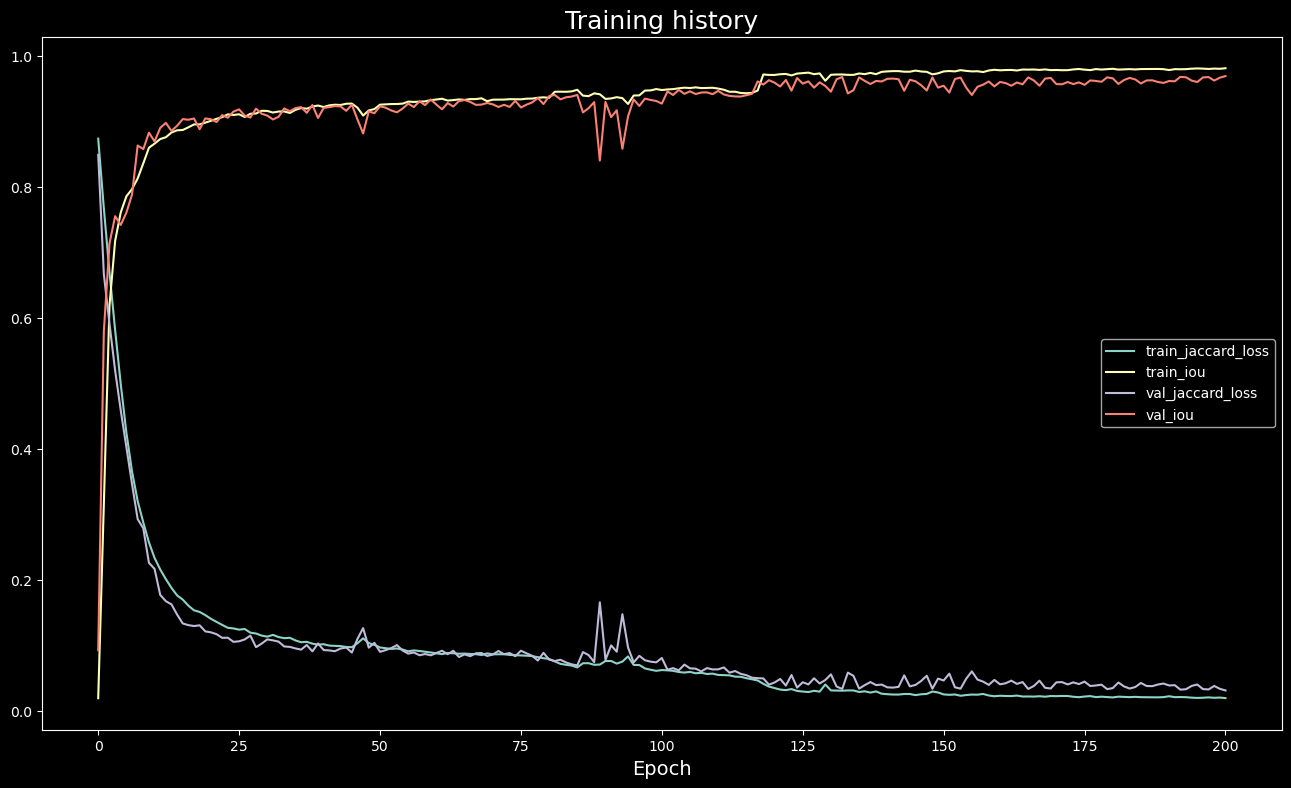

In [7]:
plt.style.use('dark_background')
plt.figure(figsize=(16, 9))
plt.plot(history, label=history.columns)
plt.title('Training history', fontsize=18)
plt.legend()
plt.xlabel('Epoch', fontsize=14)  
plt.ylabel('', fontsize=14)  
plt.show()

In [11]:
history.shape

(100, 4)

---

### Save image for presentation

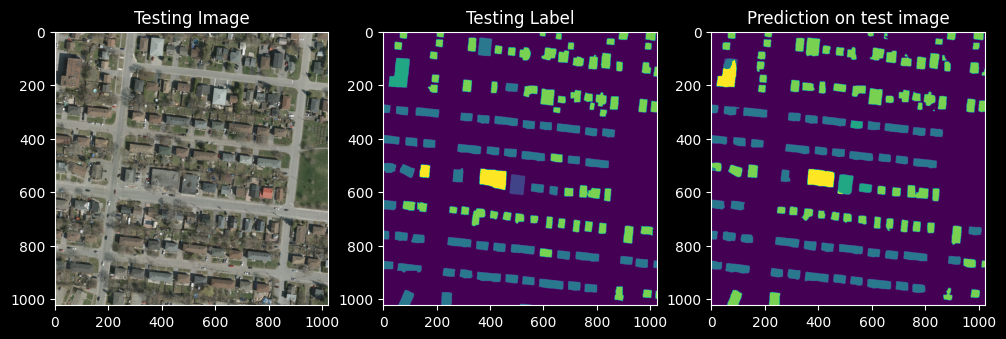

Unique values in test mask:  [0 1 2 3 4 5]
Unique values in pred mask:  [0 1 2 3 4 5]


In [79]:
figsize=(12, 8)
test_image_batch, 
test_mask_batch_argmax, 
test_pred_batch_argmax
img_num = 1

plt.style.use('dark_background')
plt.figure(figsize=figsize)
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.savefig('../data/archive/example_prediction.png', transparent=True)
plt.show()